In [1]:
import numpy as np
import nibabel as nib
import os
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import entropy

In [13]:
def extract_features(data):
    n_vols = data.shape[3]
    features = []

    for v in range(n_vols):
        vol = data[..., v]
        mean_intensity = vol.mean()
        std_intensity = vol.std()

        slice_means = vol.mean(axis=(0, 1))  # shape: (z,)
        interslice_jumps = np.abs(np.diff(slice_means)).mean()

        slice_variance = np.var(slice_means)

        features.append([mean_intensity, std_intensity, interslice_jumps, slice_variance])

    return np.array(features)

def extract_features2(data):
    n_volumes = data.shape[3]
    features = []
    for i in range(n_volumes):
        vol = data[..., i]
        flat = vol.flatten()
        hist, _ = np.histogram(flat, bins=50, density=True)
        hist += 1e-6  # avoid log(0)
        features.append([
            np.mean(flat),
            np.std(flat),
            entropy(hist),
            np.median(flat),
            np.min(flat),
            np.max(flat),
            np.mean(np.abs(np.diff(flat))),
            np.percentile(flat, 5),
            np.percentile(flat, 10),
            np.percentile(flat, 25),
            np.percentile(flat, 35),
            np.percentile(flat, 65),  
            np.percentile(flat, 75),
            np.percentile(flat, 95),
            np.max(flat) - np.min(flat)
        ])
    return np.array(features)

# MemoryError: Unable to allocate 519. GiB for an array with shape (2, 186624, 186624) and data type float64
def extract_features3(data):
    n_volumes = data.shape[3]
    features = []
    for i in range(n_volumes):
        vol = data[..., i]
        flat = vol.flatten()
        # hist, _ = np.histogram(flat, bins=50, density=True)
        # hist += 1e-6  # avoid log(0)
        features.append(flat)
    return np.array(features)

def cluster_volumes_gmm(features, n_clusters=2):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    labels = gmm.fit_predict(X_scaled)

    return labels, gmm.predict_proba(X_scaled), gmm

def plot_clusters(features, labels, title="GMM Clustering"):
    from sklearn.decomposition import PCA
    X_reduced = PCA(n_components=2).fit_transform(features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_PCA(features, labels, title="PCA Projection"):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    pca = PCA()
    X_pca = pca.fit_transform(features)  # X is your volume features (n_volumes x n_features)

    plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
def plot_TSNE(features, labels, title="t-SNE Projection"):
    from sklearn.manifold import TSNE
    X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(features)

    plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
    plt.title("t-SNE Embedding of Volumes")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


def run_pipeline(file_path):
    print(f"Processing: {os.path.basename(file_path)}")
    data = nib.load(file_path).get_fdata()
    features = extract_features2(data)
    print(f"Extracted features shape: {features.shape}")
    labels, probs, gmm = cluster_volumes_gmm(features)

    # df = pd.DataFrame(features, columns=["Mean", "Std", "SliceJump", "SliceVar"])
    # df["Cluster"] = labels
    # df.to_csv("volume_clusters.csv", index=False)

    # Count volumes per class
    count0 = np.sum(labels == 0)
    count1 = np.sum(labels == 1)
    print(f"Cluster 0: {count0} volumes | Cluster 1: {count1} volumes")

    plot_clusters(features, labels, title=f"GMM Clustering for {os.path.basename(file_path)}")
    
    plot_PCA(features, labels, title=f"PCA Projection for {os.path.basename(file_path)}")
    
    plot_TSNE(features, labels, title=f"t-SNE Projection for {os.path.basename(file_path)}")

    return labels, probs, 1

Processing: artif_01_bold.nii.gz
Extracted features shape: (836, 15)
Cluster 0: 738 volumes | Cluster 1: 98 volumes


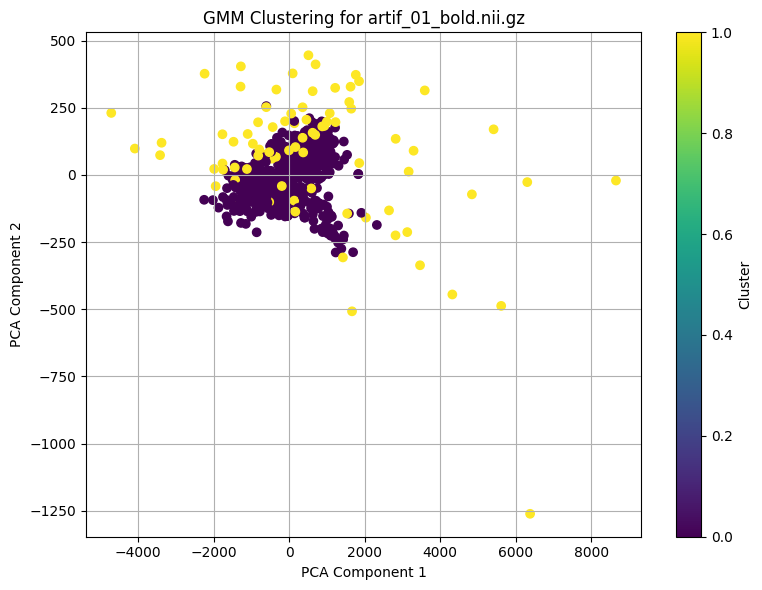

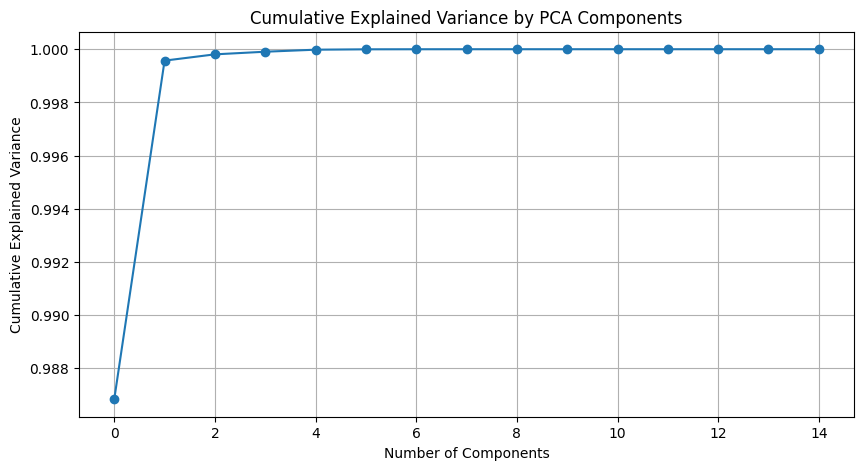

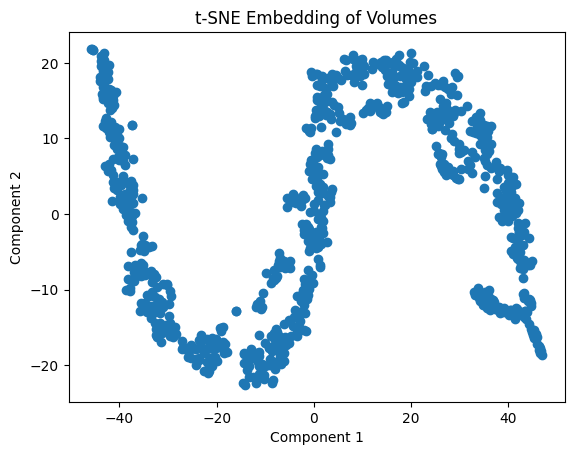

In [14]:
# ----------- RUN ------------
file_path = r'C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\artif_01_bold.nii.gz'
labels, probs, df = run_pipeline(file_path)

Processing: clean_01_bold.nii.gz
Extracted features shape: (837, 7)
Cluster 0: 55 volumes | Cluster 1: 782 volumes


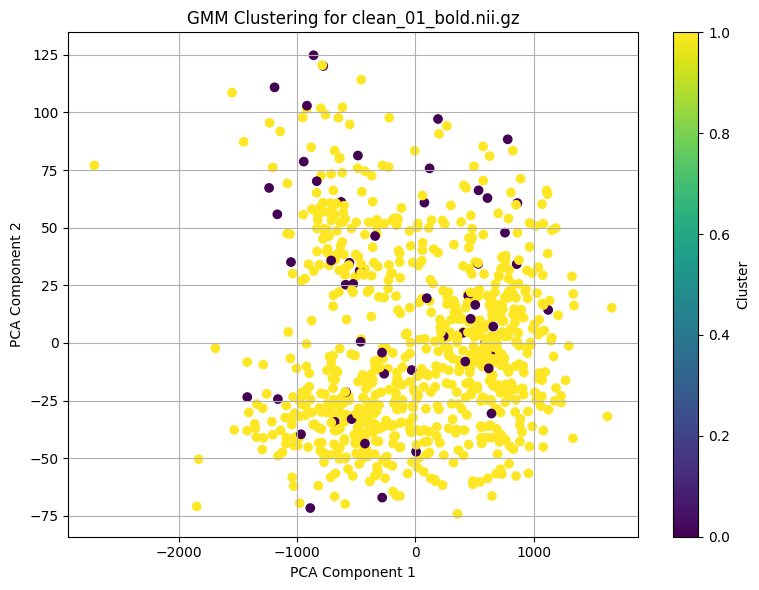

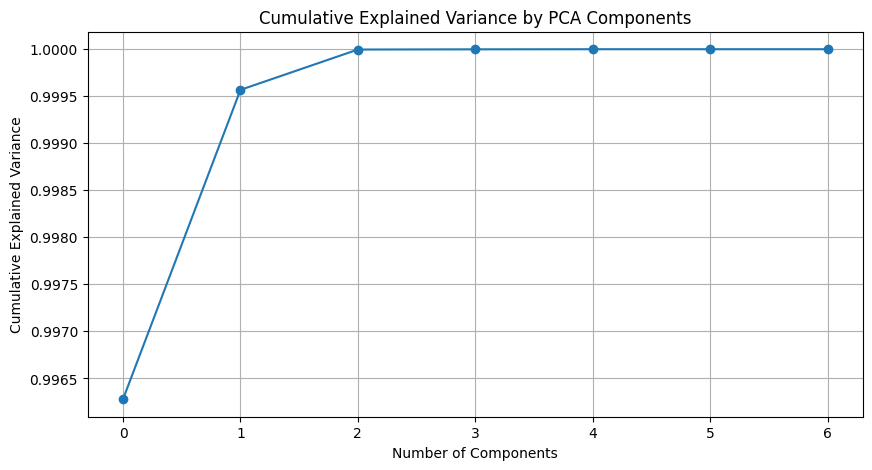

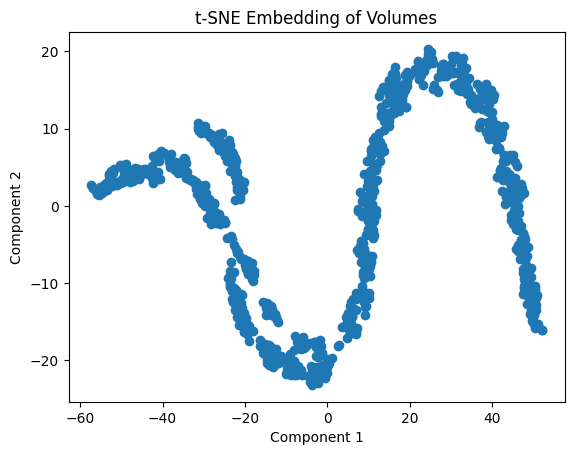

In [ ]:
file_path = r'C:\Users\Student11\Documents\git\MedImaging\mi2025_t03\MI2022_TeamWork_data\clean_01_bold.nii.gz'
labels, probs, df = run_pipeline(file_path)